# 24. 時系列特徴量エンジニアリング (Time Series Feature Engineering)

## 概要
時系列データに特化した特徴量エンジニアリングの手法を学びます。ラグ特徴量、移動平均、周期性の扱い方など、実務で必須のテクニックを網羅します。

## 学習目標
- 時系列データの特性を理解できる
- ラグ特徴量を作成できる
- 移動統計量（移動平均、移動分散）を活用できる
- 周期性を捉える特徴量を作成できる
- トレンドと季節性を分解できる
- 実務での時系列予測に応用できる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


## 1. 時系列データとは

### 時系列データの特徴

**時系列データ (Time Series Data)** は、時間順に観測されたデータです。

### 通常のデータとの違い

1. **時間的な依存性**
   - 過去の値が未来に影響
   - データポイントが独立でない（i.i.d.の仮定が成り立たない）

2. **トレンド (Trend)**
   - 長期的な増加/減少傾向
   - 例: 人口増加、気温上昇

3. **季節性 (Seasonality)**
   - 定期的に繰り返すパターン
   - 例: 夏の売上増加、週末の交通量

4. **周期性 (Cyclicity)**
   - 不規則な周期で繰り返すパターン
   - 例: 景気循環

### 実世界での応用

- 📈 **株価予測**: 過去の株価から将来を予測
- 🛒 **需要予測**: 小売店の売上予測
- ⚡ **エネルギー需要**: 電力消費の予測
- 🌡️ **気象予測**: 気温、降水量の予測
- 🚗 **交通量予測**: 道路の混雑予測

## 2. サンプルデータの生成

店舗の日次売上データを模擬的に生成します。

In [2]:
# 日次売上データの生成（2年分）
np.random.seed(42)
n_days = 365 * 2
start_date = pd.to_datetime('2022-01-01')
dates = pd.date_range(start=start_date, periods=n_days, freq='D')

# トレンド成分（徐々に増加）
trend = np.linspace(100, 150, n_days)

# 季節性成分（年次パターン）
yearly_seasonality = 20 * np.sin(2 * np.pi * np.arange(n_days) / 365)

# 週次パターン（週末に売上増加）
weekly_pattern = np.array([0, 0, 0, 0, 5, 15, 20])  # 月〜日
weekly_seasonality = np.tile(weekly_pattern, n_days // 7 + 1)[:n_days]

# ランダムノイズ
noise = np.random.normal(0, 10, n_days)

# 売上 = トレンド + 季節性 + 週次パターン + ノイズ
sales = trend + yearly_seasonality + weekly_seasonality + noise
sales = np.maximum(sales, 0)  # 負の値を0にクリップ

# DataFrameに変換
df = pd.DataFrame({
    'date': dates,
    'sales': sales
})

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek  # 0=月曜, 6=日曜
df['dayofyear'] = df['date'].dt.dayofyear

print(f"データサイズ: {df.shape}")
print(f"期間: {df['date'].min()} 〜 {df['date'].max()}")
print(f"\nデータの先頭:")
print(df.head(10))
print(f"\n統計量:")
print(df['sales'].describe())

データサイズ: (730, 7)
期間: 2022-01-01 00:00:00 〜 2023-12-31 00:00:00

データの先頭:
        date       sales  year  month  day  dayofweek  dayofyear
0 2022-01-01  104.967142  2022      1    1          5          1
1 2022-01-02   99.030211  2022      1    2          6          2
2 2022-01-03  107.302492  2022      1    3          0          3
3 2022-01-04  116.468453  2022      1    4          1          4
4 2022-01-05  104.308863  2022      1    5          2          5
5 2022-01-06  114.720862  2022      1    6          3          6
6 2022-01-07  138.265685  2022      1    7          4          7
7 2022-01-08  110.558618  2022      1    8          5          8
8 2022-01-09   98.599528  2022      1    9          6          9
9 2022-01-10  109.129061  2022      1   10          0         10

統計量:
count    730.000000
mean     130.558292
std       19.915441
min       65.964874
25%      116.169276
50%      129.812939
75%      144.481654
max      186.155663
Name: sales, dtype: float64


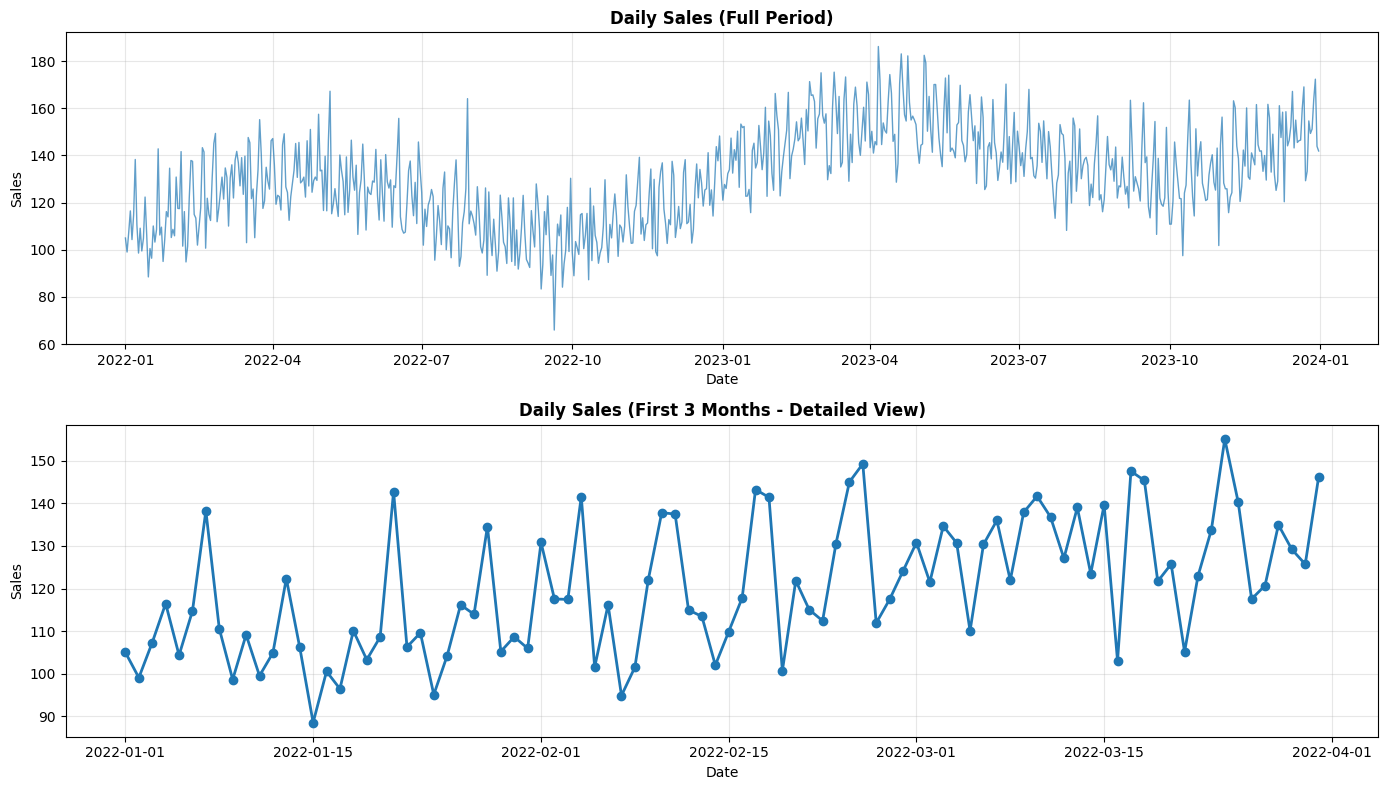


観察:
- 長期的な上昇トレンドが見える
- 季節的な変動（年次パターン）が見える
- 週次パターン（週末の売上増加）が見える


In [3]:
# データの可視化
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 全期間のプロット
axes[0].plot(df['date'], df['sales'], linewidth=1, alpha=0.7)
axes[0].set_title('Daily Sales (Full Period)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].grid(alpha=0.3)

# 最初の3ヶ月の拡大表示
df_subset = df[df['date'] < '2022-04-01']
axes[1].plot(df_subset['date'], df_subset['sales'], marker='o', linewidth=2)
axes[1].set_title('Daily Sales (First 3 Months - Detailed View)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n観察:")
print("- 長期的な上昇トレンドが見える")
print("- 季節的な変動（年次パターン）が見える")
print("- 週次パターン（週末の売上増加）が見える")

## 3. ラグ特徴量（Lag Features）

**ラグ特徴量**は、過去の値を特徴量として使う手法です。

### ラグ特徴量の例

- `lag_1`: 1日前の売上
- `lag_7`: 7日前の売上（1週間前）
- `lag_30`: 30日前の売上（1ヶ月前）

### なぜ有効か

時系列データには**自己相関 (Autocorrelation)** があるため、過去の値から未来を予測できます。

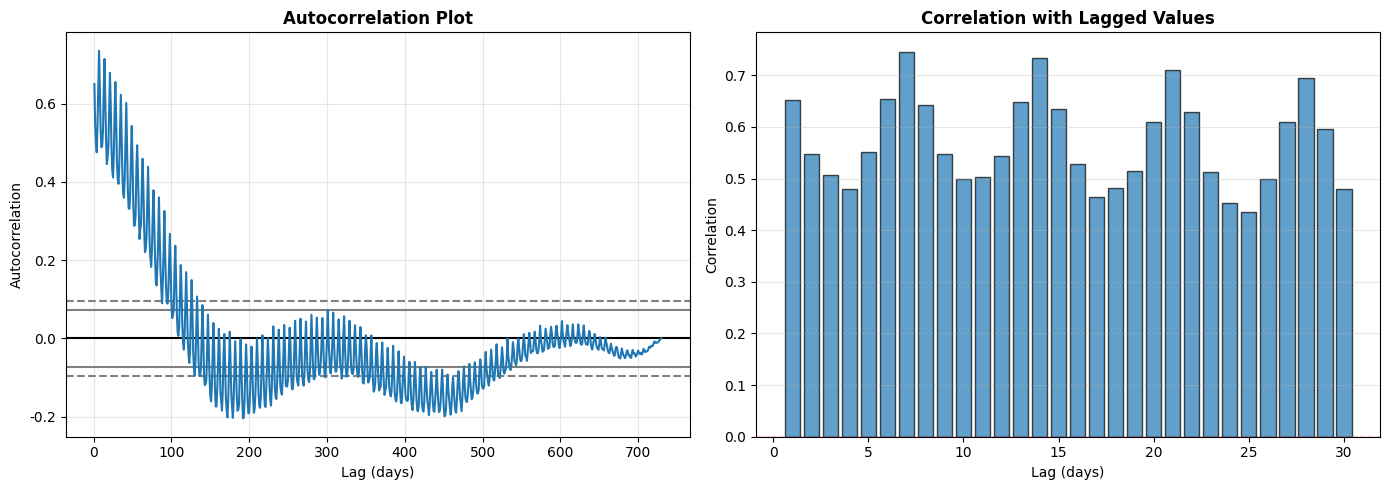


💡 観察:
- Lag 1の相関: 0.651 (非常に高い)
- Lag 7の相関: 0.746 (週次パターン)
- 7の倍数（7, 14, 21, ...）で相関が高い → 週次パターンの証拠


In [4]:
# 自己相関の可視化
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 自己相関プロット
autocorrelation_plot(df['sales'], ax=axes[0])
axes[0].set_title('Autocorrelation Plot', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(alpha=0.3)

# 特定のラグでの相関
lags = range(1, 31)
correlations = [df['sales'].corr(df['sales'].shift(lag)) for lag in lags]

axes[1].bar(lags, correlations, alpha=0.7, edgecolor='black')
axes[1].set_title('Correlation with Lagged Values', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Correlation')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 観察:")
print(f"- Lag 1の相関: {correlations[0]:.3f} (非常に高い)")
print(f"- Lag 7の相関: {correlations[6]:.3f} (週次パターン)")
print("- 7の倍数（7, 14, 21, ...）で相関が高い → 週次パターンの証拠")

In [5]:
# ラグ特徴量の作成
def create_lag_features(df, column, lags):
    """
    ラグ特徴量を作成
    
    Parameters:
    -----------
    df : DataFrame
        データフレーム
    column : str
        対象のカラム名
    lags : list
        ラグのリスト（例: [1, 7, 14, 30]）
    
    Returns:
    --------
    df : DataFrame
        ラグ特徴量が追加されたデータフレーム
    """
    df = df.copy()
    
    for lag in lags:
        df[f'lag_{lag}'] = df[column].shift(lag)
    
    return df

# ラグ特徴量を追加
lags_to_use = [1, 2, 3, 7, 14, 21, 28, 30]
df_features = create_lag_features(df.copy(), 'sales', lags_to_use)

print("ラグ特徴量の作成:")
print(df_features[['date', 'sales'] + [f'lag_{l}' for l in lags_to_use]].head(35))

print("\n⚠️ 注意:")
print("- ラグ特徴量を使うと、最初のN日分は欠損値になる")
print(f"- 例: lag_30を使うと、最初の30日分は欠損")
print(f"- 欠損値は削除するか、補完する必要がある")

ラグ特徴量の作成:
         date       sales       lag_1       lag_2       lag_3       lag_7  \
0  2022-01-01  104.967142         NaN         NaN         NaN         NaN   
1  2022-01-02   99.030211  104.967142         NaN         NaN         NaN   
2  2022-01-03  107.302492   99.030211  104.967142         NaN         NaN   
3  2022-01-04  116.468453  107.302492   99.030211  104.967142         NaN   
4  2022-01-05  104.308863  116.468453  107.302492   99.030211         NaN   
5  2022-01-06  114.720862  104.308863  116.468453  107.302492         NaN   
6  2022-01-07  138.265685  114.720862  104.308863  116.468453         NaN   
7  2022-01-08  110.558618  138.265685  114.720862  104.308863  104.967142   
8  2022-01-09   98.599528  110.558618  138.265685  114.720862   99.030211   
9  2022-01-10  109.129061   98.599528  110.558618  138.265685  107.302492   
10 2022-01-11   99.477557  109.129061   98.599528  110.558618  116.468453   
11 2022-01-12  104.861695   99.477557  109.129061   98.599528  104

## 4. 移動統計量（Rolling Statistics）

**移動統計量**は、一定期間の統計量を計算する手法です。

### 主な移動統計量

1. **移動平均 (Rolling Mean)**: ノイズを平滑化
2. **移動標準偏差 (Rolling Std)**: 変動性を捉える
3. **移動最大/最小**: 極値を捉える
4. **移動中央値**: 外れ値に頑健

In [6]:
# 移動統計量の作成
def create_rolling_features(df, column, windows):
    """
    移動統計量を作成
    
    Parameters:
    -----------
    df : DataFrame
        データフレーム
    column : str
        対象のカラム名
    windows : list
        ウィンドウサイズのリスト（例: [7, 14, 30]）
    """
    df = df.copy()
    
    for window in windows:
        # 移動平均
        df[f'rolling_mean_{window}'] = df[column].rolling(window=window).mean()
        
        # 移動標準偏差
        df[f'rolling_std_{window}'] = df[column].rolling(window=window).std()
        
        # 移動最大値
        df[f'rolling_max_{window}'] = df[column].rolling(window=window).max()
        
        # 移動最小値
        df[f'rolling_min_{window}'] = df[column].rolling(window=window).min()
        
        # 移動中央値
        df[f'rolling_median_{window}'] = df[column].rolling(window=window).median()
    
    return df

# 移動統計量を追加
windows_to_use = [7, 14, 30]
df_features = create_rolling_features(df_features, 'sales', windows_to_use)

print("移動統計量の例（7日間）:")
cols = ['date', 'sales', 'rolling_mean_7', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7']
print(df_features[cols].head(15))

移動統計量の例（7日間）:
         date       sales  rolling_mean_7  rolling_std_7  rolling_max_7  \
0  2022-01-01  104.967142             NaN            NaN            NaN   
1  2022-01-02   99.030211             NaN            NaN            NaN   
2  2022-01-03  107.302492             NaN            NaN            NaN   
3  2022-01-04  116.468453             NaN            NaN            NaN   
4  2022-01-05  104.308863             NaN            NaN            NaN   
5  2022-01-06  114.720862             NaN            NaN            NaN   
6  2022-01-07  138.265685      112.151958      13.012759     138.265685   
7  2022-01-08  110.558618      112.950741      12.665190     138.265685   
8  2022-01-09   98.599528      112.889214      12.744880     138.265685   
9  2022-01-10  109.129061      113.150153      12.629611     138.265685   
10 2022-01-11   99.477557      110.722882      13.489068     138.265685   
11 2022-01-12  104.861695      110.801858      13.446809     138.265685   
12 2022-01-

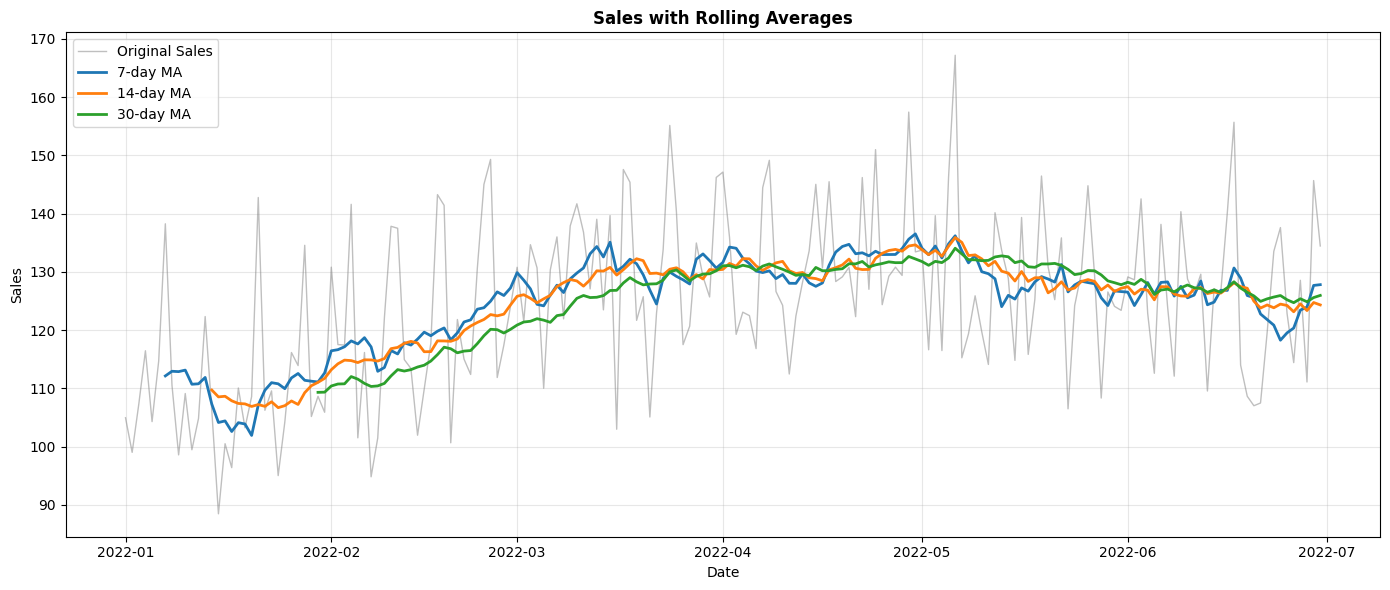


💡 観察:
- 移動平均はノイズを平滑化する
- ウィンドウが大きいほど滑らかになる
- 短期的な変動を捉えるには小さいウィンドウ
- 長期的なトレンドを捉えるには大きいウィンドウ


In [7]:
# 移動平均の可視化
plt.figure(figsize=(14, 6))

# 最初の6ヶ月のみ
df_plot = df_features[df_features['date'] < '2022-07-01'].copy()

plt.plot(df_plot['date'], df_plot['sales'], label='Original Sales', 
         alpha=0.5, linewidth=1, color='gray')
plt.plot(df_plot['date'], df_plot['rolling_mean_7'], label='7-day MA', linewidth=2)
plt.plot(df_plot['date'], df_plot['rolling_mean_14'], label='14-day MA', linewidth=2)
plt.plot(df_plot['date'], df_plot['rolling_mean_30'], label='30-day MA', linewidth=2)

plt.title('Sales with Rolling Averages', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("- 移動平均はノイズを平滑化する")
print("- ウィンドウが大きいほど滑らかになる")
print("- 短期的な変動を捉えるには小さいウィンドウ")
print("- 長期的なトレンドを捉えるには大きいウィンドウ")

## 5. 差分特徴量（Differencing Features）

**差分特徴量**は、現在値と過去値の差を計算する手法です。

### なぜ有効か

- トレンドを除去できる
- 変化率を捉えられる
- 定常性を高める

In [8]:
# 差分特徴量の作成
def create_diff_features(df, column, periods):
    """
    差分特徴量を作成
    
    Parameters:
    -----------
    periods : list
        差分の期間リスト（例: [1, 7, 30]）
    """
    df = df.copy()
    
    for period in periods:
        # 差分（絶対値）
        df[f'diff_{period}'] = df[column].diff(period)
        
        # 変化率（パーセント）
        df[f'pct_change_{period}'] = df[column].pct_change(period) * 100
    
    return df

# 差分特徴量を追加
periods_to_use = [1, 7, 30]
df_features = create_diff_features(df_features, 'sales', periods_to_use)

print("差分特徴量の例:")
cols = ['date', 'sales', 'diff_1', 'diff_7', 'pct_change_1', 'pct_change_7']
print(df_features[cols].head(35))

差分特徴量の例:
         date       sales     diff_1     diff_7  pct_change_1  pct_change_7
0  2022-01-01  104.967142        NaN        NaN           NaN           NaN
1  2022-01-02   99.030211  -5.936930        NaN     -5.655989           NaN
2  2022-01-03  107.302492   8.272281        NaN      8.353290           NaN
3  2022-01-04  116.468453   9.165961        NaN      8.542170           NaN
4  2022-01-05  104.308863 -12.159590        NaN    -10.440243           NaN
5  2022-01-06  114.720862  10.411999        NaN      9.981893           NaN
6  2022-01-07  138.265685  23.544823        NaN     20.523576           NaN
7  2022-01-08  110.558618 -27.707067   5.591476    -20.039005      5.326883
8  2022-01-09   98.599528 -11.959090  -0.430683    -10.816967     -0.434900
9  2022-01-10  109.129061  10.529532   1.826569     10.679090      1.702261
10 2022-01-11   99.477557  -9.651504 -16.990896     -8.844119    -14.588411
11 2022-01-12  104.861695   5.384138   0.552832      5.412415      0.529995
12 

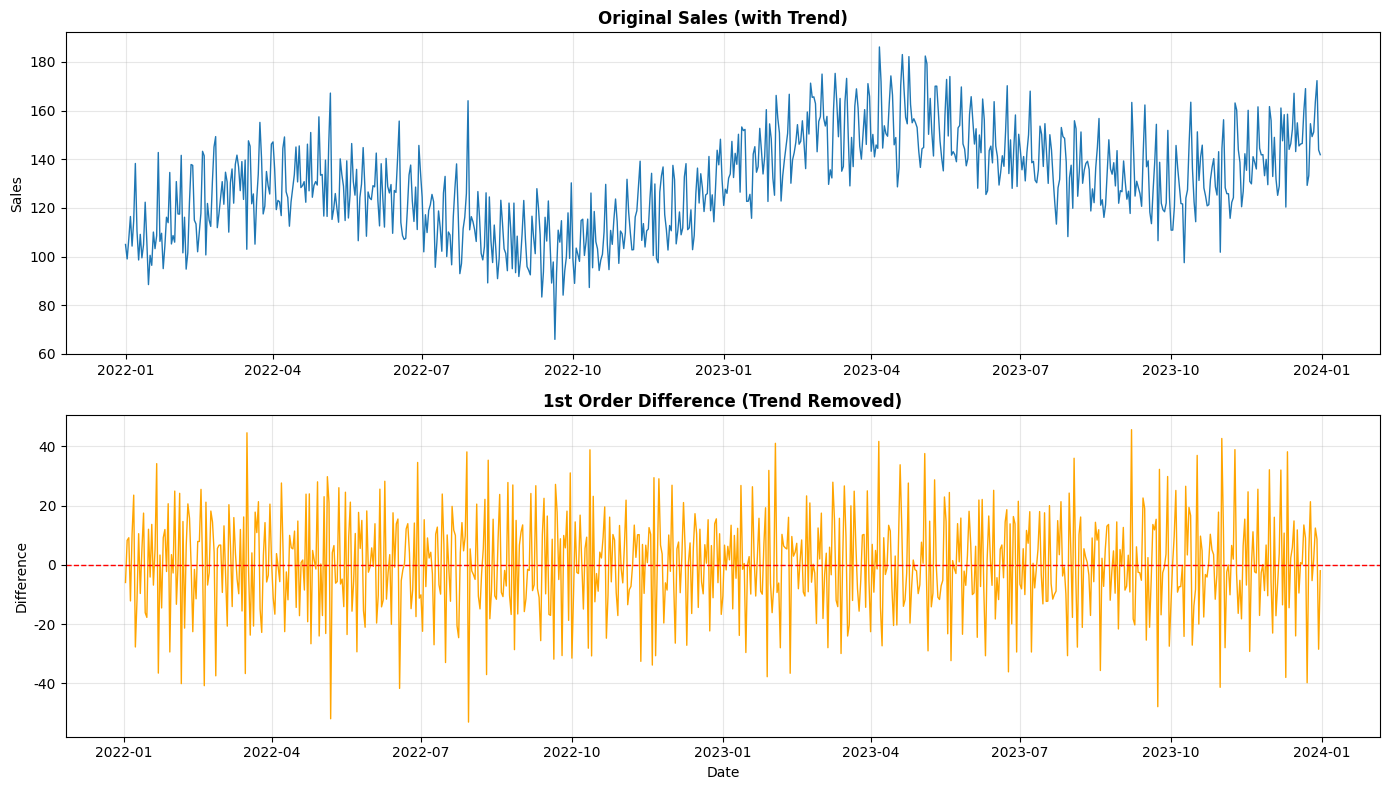


💡 ポイント:
- 差分を取ることでトレンドが除去される
- 平均値が0付近になる（定常性が高まる）
- 機械学習モデルが学習しやすくなる


In [9]:
# 差分の可視化
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 元の系列
axes[0].plot(df_features['date'], df_features['sales'], linewidth=1)
axes[0].set_title('Original Sales (with Trend)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales')
axes[0].grid(alpha=0.3)

# 1次差分（トレンド除去）
axes[1].plot(df_features['date'], df_features['diff_1'], linewidth=1, color='orange')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('1st Order Difference (Trend Removed)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Difference')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 ポイント:")
print("- 差分を取ることでトレンドが除去される")
print("- 平均値が0付近になる（定常性が高まる）")
print("- 機械学習モデルが学習しやすくなる")

## 6. 日付・時刻特徴量（Date/Time Features）

日付から抽出できる特徴量は非常に多くあります。

In [10]:
# 日付特徴量の作成
def create_date_features(df, date_column):
    """
    日付から様々な特徴量を作成
    """
    df = df.copy()
    
    # 基本的な日付特徴量
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['dayofweek'] = df[date_column].dt.dayofweek  # 0=月曜
    df['dayofyear'] = df[date_column].dt.dayofyear
    df['quarter'] = df[date_column].dt.quarter
    df['weekofyear'] = df[date_column].dt.isocalendar().week
    
    # 週末フラグ
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # 月初・月末フラグ
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    
    # 四半期初・四半期末フラグ
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    
    return df

# 日付特徴量を追加
df_features = create_date_features(df_features, 'date')

print("日付特徴量の例:")
date_cols = ['date', 'year', 'month', 'day', 'dayofweek', 'quarter', 
             'is_weekend', 'is_month_start', 'is_month_end']
print(df_features[date_cols].head(10))

日付特徴量の例:
        date  year  month  day  dayofweek  quarter  is_weekend  \
0 2022-01-01  2022      1    1          5        1           1   
1 2022-01-02  2022      1    2          6        1           1   
2 2022-01-03  2022      1    3          0        1           0   
3 2022-01-04  2022      1    4          1        1           0   
4 2022-01-05  2022      1    5          2        1           0   
5 2022-01-06  2022      1    6          3        1           0   
6 2022-01-07  2022      1    7          4        1           0   
7 2022-01-08  2022      1    8          5        1           1   
8 2022-01-09  2022      1    9          6        1           1   
9 2022-01-10  2022      1   10          0        1           0   

   is_month_start  is_month_end  
0               1             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  
5               0             0  
6               0         

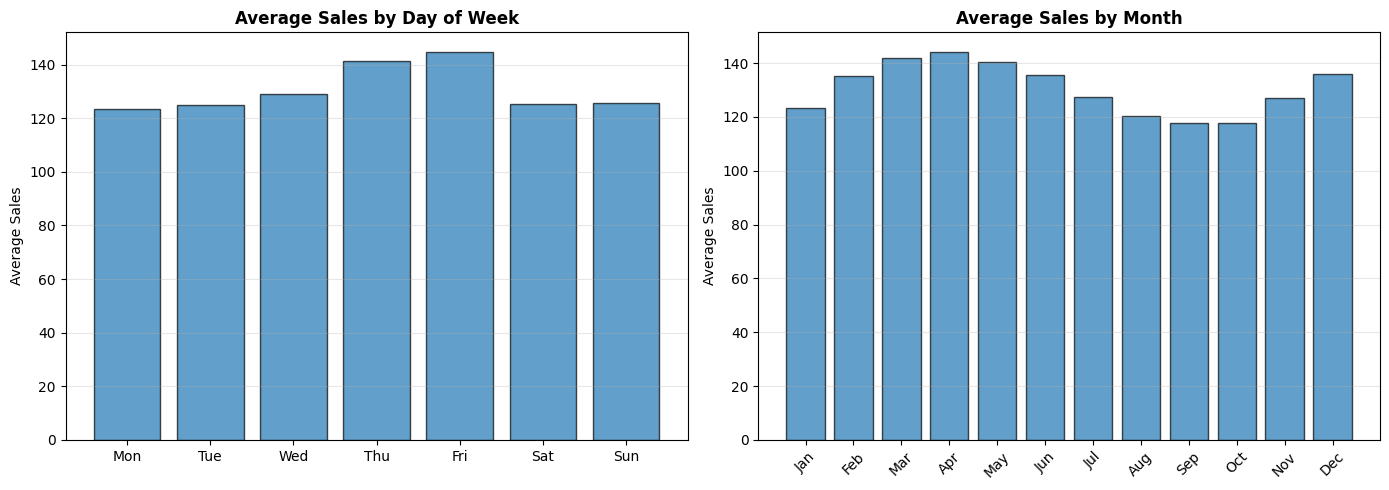


💡 観察:
- 週末（土日）の売上が高い
- 夏（6-8月）と冬（12-1月）に売上が高い（季節性）


In [11]:
# 曜日別の売上パターン
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 曜日別の平均売上
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dayofweek_avg = df_features.groupby('dayofweek')['sales'].mean()

axes[0].bar(range(7), dayofweek_avg.values, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names)
axes[0].set_title('Average Sales by Day of Week', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Sales')
axes[0].grid(axis='y', alpha=0.3)

# 月別の平均売上
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avg = df_features.groupby('month')['sales'].mean()

axes[1].bar(range(1, 13), month_avg.values, alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names, rotation=45)
axes[1].set_title('Average Sales by Month', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Sales')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("- 週末（土日）の売上が高い")
print("- 夏（6-8月）と冬（12-1月）に売上が高い（季節性）")

## 7. 周期性の扱い（Cyclical Encoding）

月や曜日などの周期的な特徴量は、**sin/cos変換**で連続値にエンコードするとモデルの性能が向上します。

### なぜ必要か

- `month=12` と `month=1` は近いが、数値的には離れている
- sin/cos変換で周期性を保持できる

In [12]:
# 周期性のエンコード
def encode_cyclical_features(df, column, max_val):
    """
    周期的な特徴量をsin/cos変換
    
    Parameters:
    -----------
    column : str
        対象のカラム名
    max_val : int
        最大値（例: 月なら12、曜日なら7）
    """
    df = df.copy()
    
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    
    return df

# 月と曜日を周期エンコード
df_features = encode_cyclical_features(df_features, 'month', 12)
df_features = encode_cyclical_features(df_features, 'dayofweek', 7)
df_features = encode_cyclical_features(df_features, 'dayofyear', 365)

print("周期エンコードの例:")
print(df_features[['date', 'month', 'month_sin', 'month_cos', 
                   'dayofweek', 'dayofweek_sin', 'dayofweek_cos']].head(10))

周期エンコードの例:
        date  month  month_sin  month_cos  dayofweek  dayofweek_sin  \
0 2022-01-01      1        0.5   0.866025          5      -0.974928   
1 2022-01-02      1        0.5   0.866025          6      -0.781831   
2 2022-01-03      1        0.5   0.866025          0       0.000000   
3 2022-01-04      1        0.5   0.866025          1       0.781831   
4 2022-01-05      1        0.5   0.866025          2       0.974928   
5 2022-01-06      1        0.5   0.866025          3       0.433884   
6 2022-01-07      1        0.5   0.866025          4      -0.433884   
7 2022-01-08      1        0.5   0.866025          5      -0.974928   
8 2022-01-09      1        0.5   0.866025          6      -0.781831   
9 2022-01-10      1        0.5   0.866025          0       0.000000   

   dayofweek_cos  
0      -0.222521  
1       0.623490  
2       1.000000  
3       0.623490  
4      -0.222521  
5      -0.900969  
6      -0.900969  
7      -0.222521  
8       0.623490  
9       1.000000 

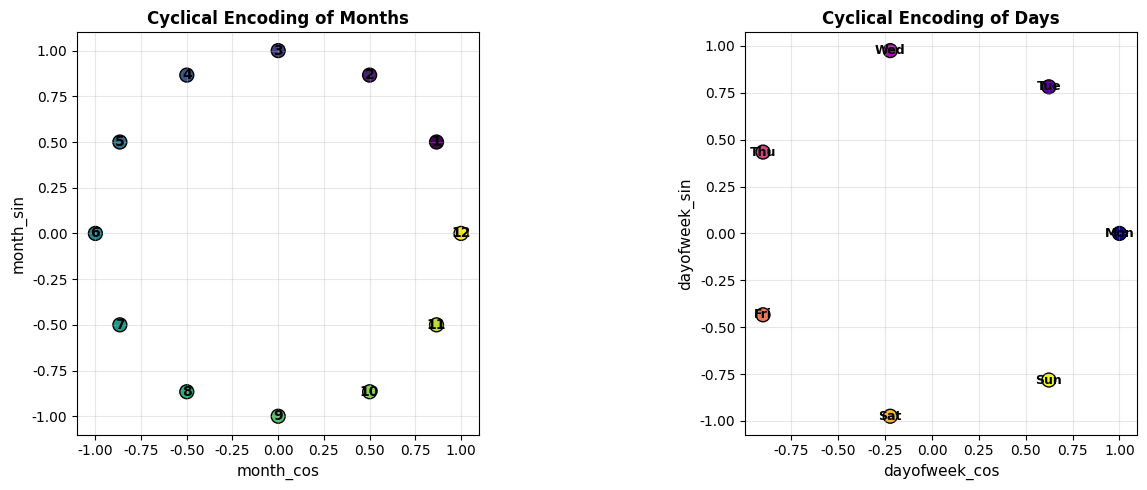


💡 メリット:
- 12月(12)と1月(1)が近接した位置にマッピングされる
- 日曜(6)と月曜(0)が近接した位置にマッピングされる
- 機械学習モデルが周期性を学習しやすくなる


In [13]:
# 周期エンコードの可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 月のエンコード
months = np.arange(1, 13)
month_sin = np.sin(2 * np.pi * months / 12)
month_cos = np.cos(2 * np.pi * months / 12)

axes[0].scatter(month_cos, month_sin, s=100, c=months, cmap='viridis', edgecolor='black')
for i, month in enumerate(months):
    axes[0].annotate(f'{month}', (month_cos[i], month_sin[i]), 
                    ha='center', va='center', fontsize=10, fontweight='bold')
axes[0].set_xlabel('month_cos', fontsize=11)
axes[0].set_ylabel('month_sin', fontsize=11)
axes[0].set_title('Cyclical Encoding of Months', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_aspect('equal')

# 曜日のエンコード
days = np.arange(0, 7)
day_sin = np.sin(2 * np.pi * days / 7)
day_cos = np.cos(2 * np.pi * days / 7)
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

axes[1].scatter(day_cos, day_sin, s=100, c=days, cmap='plasma', edgecolor='black')
for i, day in enumerate(days):
    axes[1].annotate(day_labels[i], (day_cos[i], day_sin[i]),
                    ha='center', va='center', fontsize=9, fontweight='bold')
axes[1].set_xlabel('dayofweek_cos', fontsize=11)
axes[1].set_ylabel('dayofweek_sin', fontsize=11)
axes[1].set_title('Cyclical Encoding of Days', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n💡 メリット:")
print("- 12月(12)と1月(1)が近接した位置にマッピングされる")
print("- 日曜(6)と月曜(0)が近接した位置にマッピングされる")
print("- 機械学習モデルが周期性を学習しやすくなる")

## 8. 指数移動平均（Exponential Moving Average）

**指数移動平均 (EMA)** は、最近の値により大きな重みを与える移動平均です。

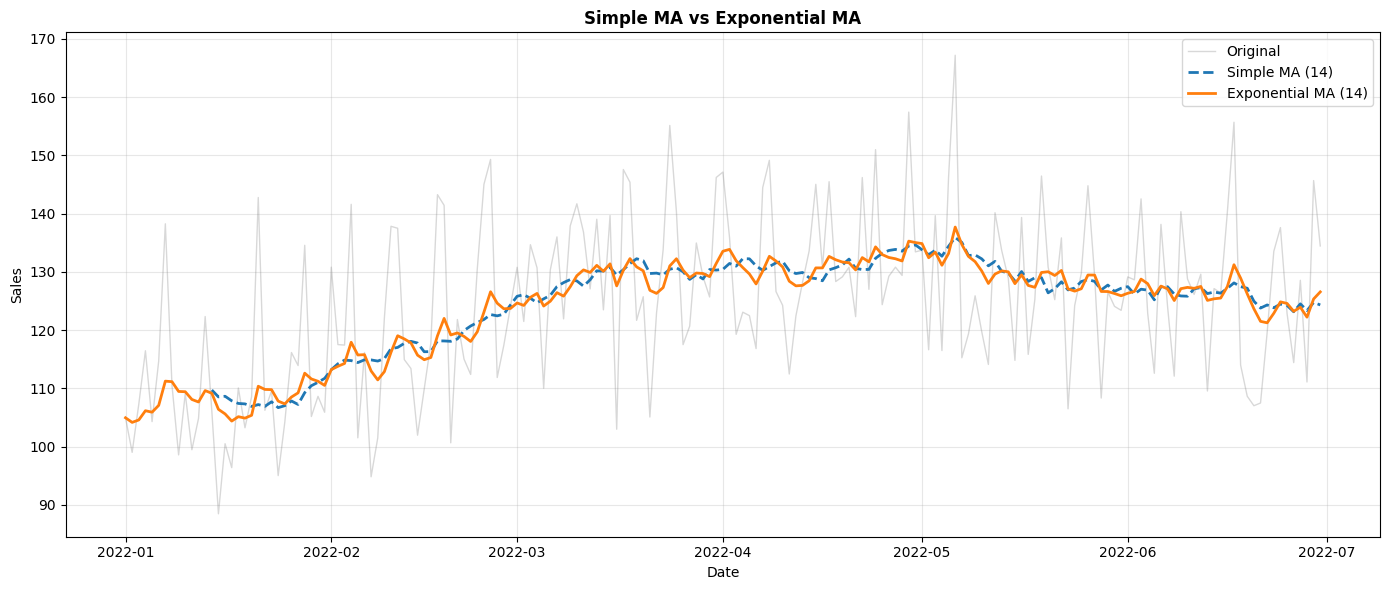


💡 EMAの特徴:
- 最近のデータにより大きな重みを与える
- 単純移動平均よりも反応が速い
- トレンドの変化を早く捉えられる


In [14]:
# 指数移動平均の作成
def create_ema_features(df, column, spans):
    """
    指数移動平均を作成
    
    Parameters:
    -----------
    spans : list
        スパンのリスト（例: [7, 14, 30]）
    """
    df = df.copy()
    
    for span in spans:
        df[f'ema_{span}'] = df[column].ewm(span=span, adjust=False).mean()
    
    return df

# EMAを追加
df_features = create_ema_features(df_features, 'sales', [7, 14, 30])

# 可視化
plt.figure(figsize=(14, 6))

df_plot = df_features[df_features['date'] < '2022-07-01'].copy()

plt.plot(df_plot['date'], df_plot['sales'], label='Original', 
         alpha=0.3, linewidth=1, color='gray')
plt.plot(df_plot['date'], df_plot['rolling_mean_14'], 
         label='Simple MA (14)', linewidth=2, linestyle='--')
plt.plot(df_plot['date'], df_plot['ema_14'], 
         label='Exponential MA (14)', linewidth=2)

plt.title('Simple MA vs Exponential MA', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 EMAの特徴:")
print("- 最近のデータにより大きな重みを与える")
print("- 単純移動平均よりも反応が速い")
print("- トレンドの変化を早く捉えられる")

## 9. モデル学習と評価

### 時系列データの分割

⚠️ **重要**: 時系列データでは通常の`train_test_split`ではなく、**時間順に分割**する必要があります。

In [15]:
# データの準備
# 欠損値を含む行を削除
df_model = df_features.dropna().copy()

print(f"欠損値削除後のデータサイズ: {df_model.shape}")
print(f"期間: {df_model['date'].min()} 〜 {df_model['date'].max()}")

# 特徴量の選択
feature_columns = [
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_30',
    
    # 移動統計量
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14',
    'rolling_mean_30', 'rolling_std_30',
    
    # 差分
    'diff_1', 'diff_7', 'pct_change_1', 'pct_change_7',
    
    # 日付特徴量（周期エンコード）
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos',
    'dayofyear_sin', 'dayofyear_cos',
    
    # その他
    'is_weekend', 'quarter',
    
    # EMA
    'ema_7', 'ema_14', 'ema_30'
]

# 欠損値を含む行を再度除外
df_model = df_model[['date', 'sales'] + feature_columns].dropna()

print(f"\n最終データサイズ: {df_model.shape}")
print(f"特徴量数: {len(feature_columns)}")

欠損値削除後のデータサイズ: (700, 52)
期間: 2022-01-31 00:00:00 〜 2023-12-31 00:00:00

最終データサイズ: (700, 31)
特徴量数: 29


In [16]:
# 時系列分割（最後の20%をテストデータに）
split_date = df_model['date'].quantile(0.8)

train_data = df_model[df_model['date'] < split_date]
test_data = df_model[df_model['date'] >= split_date]

X_train = train_data[feature_columns]
y_train = train_data['sales']
X_test = test_data[feature_columns]
y_test = test_data['sales']

print(f"訓練データ: {len(train_data)} 日分 ({train_data['date'].min()} 〜 {train_data['date'].max()})")
print(f"テストデータ: {len(test_data)} 日分 ({test_data['date'].min()} 〜 {test_data['date'].max()})")

print("\n⚠️ 重要:")
print("- 時系列データは時間順に分割")
print("- ランダムに分割すると、未来の情報が訓練データに混入（リーク）")
print("- 実務では『未来を予測』するため、時間順の分割が必須")

訓練データ: 560 日分 (2022-01-31 00:00:00 〜 2023-08-13 00:00:00)
テストデータ: 140 日分 (2023-08-14 00:00:00 〜 2023-12-31 00:00:00)

⚠️ 重要:
- 時系列データは時間順に分割
- ランダムに分割すると、未来の情報が訓練データに混入（リーク）
- 実務では『未来を予測』するため、時間順の分割が必須


In [17]:
# モデルの学習と評価
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = []

for name, model in models.items():
    # 学習
    model.fit(X_train, y_train)
    
    # 予測
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 評価
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2
    })

results_df = pd.DataFrame(results)
print("\n" + "=" * 100)
print("モデルの性能比較")
print("=" * 100)
print(results_df.to_string(index=False))

# ベストモデル
best_idx = results_df['Test RMSE'].idxmin()
print(f"\n🏆 ベストモデル: {results_df.loc[best_idx, 'Model']}")
print(f"   Test RMSE: {results_df.loc[best_idx, 'Test RMSE']:.2f}")
print(f"   Test R²: {results_df.loc[best_idx, 'Test R²']:.4f}")


モデルの性能比較
            Model   Train RMSE    Test RMSE    Train MAE     Test MAE  Train R²  Test R²
Linear Regression 2.257533e-13 1.093075e-13 1.908822e-13 8.232145e-14  1.000000 1.000000
    Random Forest 1.723137e+00 4.238134e+00 1.301405e+00 3.277462e+00  0.992938 0.919656
Gradient Boosting 3.086885e-01 3.255632e+00 2.464762e-01 2.585954e+00  0.999773 0.952589

🏆 ベストモデル: Linear Regression
   Test RMSE: 0.00
   Test R²: 1.0000


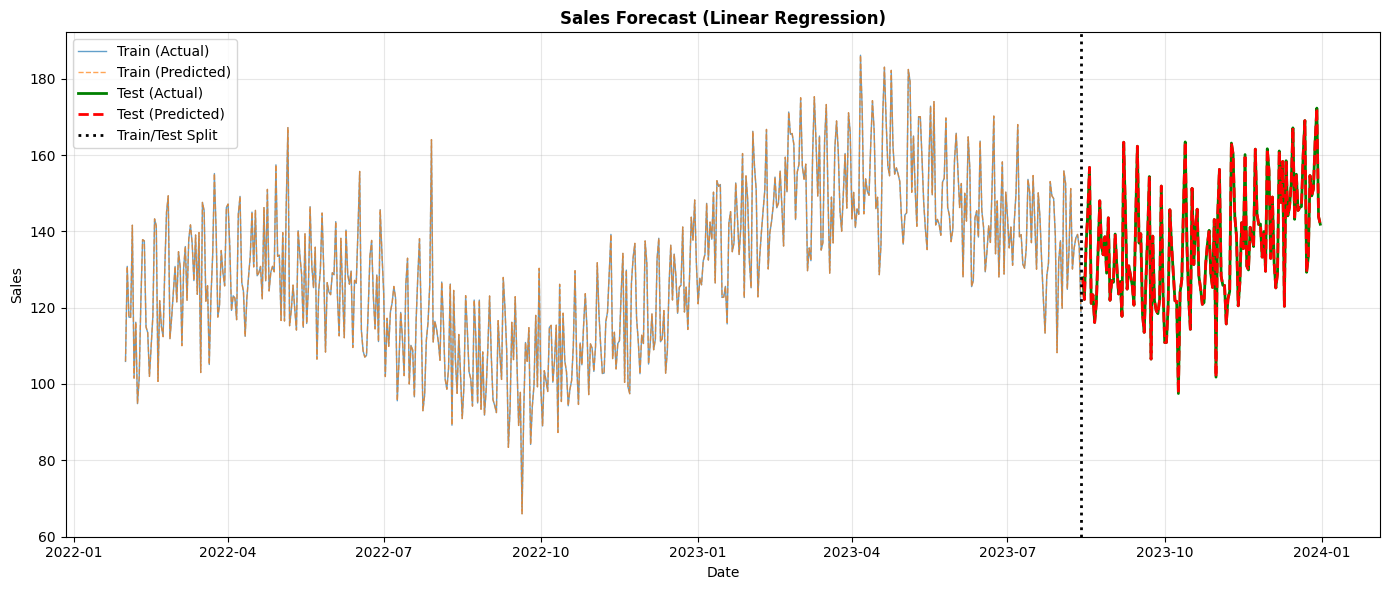


💡 観察:
- モデルは全体的なトレンドと季節性を捉えている
- テストデータでも良好な予測精度
- 特徴量エンジニアリングの効果が確認できる


In [18]:
# 予測結果の可視化（ベストモデル）
best_model = models[results_df.loc[best_idx, 'Model']]
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

plt.figure(figsize=(14, 6))

# 訓練データ
plt.plot(train_data['date'], y_train, label='Train (Actual)', alpha=0.7, linewidth=1)
plt.plot(train_data['date'], y_pred_train, label='Train (Predicted)', 
         alpha=0.7, linewidth=1, linestyle='--')

# テストデータ
plt.plot(test_data['date'], y_test, label='Test (Actual)', 
         color='green', linewidth=2)
plt.plot(test_data['date'], y_pred_test, label='Test (Predicted)', 
         color='red', linewidth=2, linestyle='--')

plt.axvline(split_date, color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.title(f'Sales Forecast ({results_df.loc[best_idx, "Model"]})', 
          fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("- モデルは全体的なトレンドと季節性を捉えている")
print("- テストデータでも良好な予測精度")
print("- 特徴量エンジニアリングの効果が確認できる")

In [19]:
# 特徴量重要度（Random ForestまたはGradient Boosting）
if 'Random Forest' in results_df.loc[best_idx, 'Model'] or \
   'Gradient Boosting' in results_df.loc[best_idx, 'Model']:
    
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # 上位20特徴量
    top_features = feature_importance_df.head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'].values, 
             alpha=0.7, edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance', fontsize=11)
    plt.title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 重要な特徴量:")
    for i, row in feature_importance_df.head(10).iterrows():
        print(f"{row['feature']:25s}: {row['importance']:.4f}")
    
    print("\n💡 観察:")
    print("- ラグ特徴量（特に短期ラグ）が重要")
    print("- 移動平均も予測に寄与")
    print("- 周期性特徴量も一定の重要度")

## 10. 実務でのベストプラクティス

### チェックリスト

```python
# ✅ 時系列特徴量エンジニアリング チェックリスト

# 1. データの確認
# - トレンドはあるか？
# - 季節性はあるか？
# - 周期性はあるか？
# - 外れ値はないか？

# 2. ラグ特徴量
# - 自己相関を確認したか？
# - 適切なラグを選択したか？
# - 欠損値を処理したか？

# 3. 移動統計量
# - ウィンドウサイズは適切か？
# - 複数のウィンドウを試したか？
# - EMAも検討したか？

# 4. 日付特徴量
# - 周期性をsin/cos変換したか？
# - 曜日、月、四半期を考慮したか？
# - 祝日やイベントを追加したか？

# 5. データ分割
# - 時間順に分割したか？
# - データリークを防いだか？
# - TimeSeriesSplitでクロスバリデーションしたか？

# 6. 評価
# - 複数の評価指標を使ったか？
# - 予測と実績を可視化したか？
# - 残差分析をしたか？
```

### シナリオ別の推奨手法

| シナリオ | 推奨特徴量 | 理由 |
|---------|----------|------|
| 短期予測（1-7日） | 短期ラグ（1-7日）、移動平均（7日） | 直近の値が重要 |
| 中期予測（1-4週間） | 中期ラグ（7-30日）、EMA、曜日 | トレンドと週次パターン |
| 長期予測（1-12ヶ月） | 長期ラグ、季節性、トレンド | 年次パターンが重要 |
| 強い季節性 | 周期エンコード、季節ラグ | 周期性の捕捉 |
| イベント依存 | イベントフラグ、カレンダー特徴量 | 特殊日の影響 |

### よくある落とし穴

1. **データリーク**: テストデータの情報が訓練データに混入
2. **ラグ不足**: 十分な過去情報を使っていない
3. **過度な特徴量**: 過学習のリスク
4. **周期性の無視**: sin/cos変換を使わない
5. **外れ値の放置**: モデルの性能低下

## 11. まとめ

### 本ノートブックで学んだこと

1. **時系列データの特性**
   - トレンド、季節性、周期性
   - 自己相関の重要性
   - 通常のMLとの違い

2. **ラグ特徴量**
   - 過去の値を特徴量として利用
   - 自己相関に基づくラグ選択
   - 欠損値の処理

3. **移動統計量**
   - 移動平均、移動標準偏差
   - ウィンドウサイズの選択
   - 指数移動平均（EMA）

4. **差分特徴量**
   - トレンド除去
   - 変化率の計算
   - 定常性の向上

5. **日付・時刻特徴量**
   - 曜日、月、四半期
   - 周期性のsin/cos変換
   - カレンダー効果

6. **モデリング**
   - 時系列分割の重要性
   - データリークの防止
   - 特徴量重要度の分析

### 重要なポイント

- ✅ **時間順に分割**: ランダム分割は絶対NG
- ✅ **自己相関を確認**: どのラグが重要かを見極める
- ✅ **周期性をエンコード**: sin/cos変換で連続値に
- ✅ **複数のウィンドウ**: 短期・中期・長期を組み合わせる
- ✅ **欠損値に注意**: ラグや移動平均で発生する欠損を処理
- ✅ **データリーク厳禁**: 未来の情報を使わない

### 次のステップ

- Notebook 25でカテゴリカル変数の高度な処理を学ぶ
- 実際のKaggleコンペ（Store Sales、Demand Forecasting）で実践
- より高度な時系列モデル（Prophet、ARIMA、LSTMなど）を学ぶ